In [36]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "earthquake"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Importing data and looking at it

In [37]:
import pandas as pd

def load_data(data_path = "datasets"):
    csv_path_train = os.path.join(data_path, "train.csv")
#    csv_path_test = os.path.join(data_path, "test.csv")
    csv_path_sample_submission = os.path.join(data_path, "sample_submission.csv")
    return pd.read_csv(csv_path_train), pd.read_csv(csv_path_sample_submission)

In [38]:
def load_test(data_path = "datasets/test"):
    num_files = len(os.listdir(data_path))
    test_list = []
    for path in os.listdir(data_path):
        csv_path = os.path.join(data_path, path)
        test_list.append(pd.read_csv(csv_path))
    return test_list

In [39]:
train, sample = load_data()

In [40]:
test = load_test()

In [12]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [13]:
print("Number of test files", len(test))

Number of test files 2624


In [23]:
test[0].head()

,acoustic_data
0,2
1,6
2,5
3,6
4,9


In [24]:
train.describe()

,acoustic_data,time_to_failure
count,6.291455e+08,6.291455e+08
mean,4.519468e+00,5.678292e+00
std,1.073571e+01,3.672697e+00
min,-5.515000e+03,9.550396e-05
25%,2.000000e+00,2.625997e+00
50%,5.000000e+00,5.349798e+00
75%,7.000000e+00,8.173396e+00
max,5.444000e+03,1.610740e+01


In [29]:
for i in range(3):
    print(test[i].describe(),'\n')

       acoustic_data
count  150000.000000
mean        4.333713
std         6.130020
min      -176.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       185.000000 

       acoustic_data
count  150000.000000
mean        3.749993
std        13.897649
min      -353.000000
25%         1.000000
50%         4.000000
75%         6.000000
max       605.000000 

       acoustic_data
count  150000.000000
mean        4.107000
std         4.333725
min       -42.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        54.000000 



In [262]:
sample.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [259]:
len(sample)

2624

In [190]:
train_ad = train["acoustic_data"].values
train_ttf = train["time_to_failure"].values

### A useful plot function

In [247]:
def plot_activity(t_init, duration, x_scale=None, ad_data=train_ad, ttf_data=train_ttf):
    if t_init < 0:
        t_init = 0
    if t_init + duration > len(ad_data):
        duration = len(ad_data) - t_init
    if x_scale:
        fig, ax1 = plt.subplots(figsize=(8*x_scale,4))
    else:
        fig, ax1 = plt.subplots()

    ax1.set_xlabel('shifted (rescaled) time (s)', fontsize=15)
    ax1.set_ylabel("acoustic data", fontsize=15, color='b')
    ax1.plot(ad_data[t_init:(t_init+duration)], 'b--')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('ttf', fontsize=15, color='r')
    ax2.plot(ttf_data[t_init:(t_init+duration)], 'r.')

    plt.show()

Let's plot the whole training set, sampling 1%.

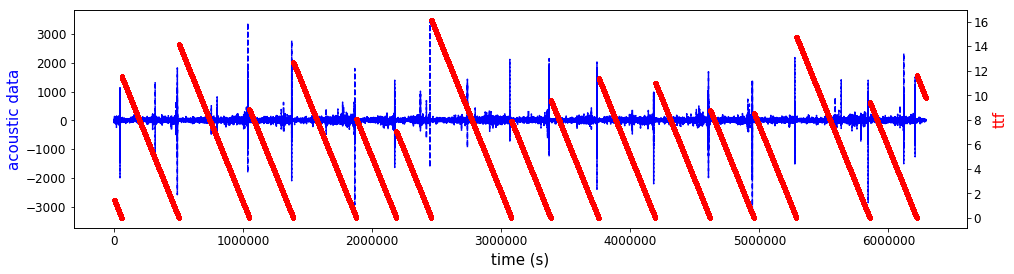

In [230]:
train_ad_sample = train_ad[::100]
train_ttf_sample = train_ttf[::100]

plot_activity(0,int(len(train_ad)/100), x_scale=2, ad_data = train_ad_sample, ttf_data = train_ttf_sample)

Let's look closer at the ttf jumps.

In [114]:
m = len(train)

In [195]:
train0 = train_ttf[:(m-1)]
train1 = train_ttf[1:]

In [196]:
jumps0 = (train0 < train1)

In [197]:
jumps = np.where(jumps0 == 1)[0]

In [198]:
jumps

array([  5656573,  50085877, 104677355, 138772452, 187641819, 218652629,
       245829584, 307838916, 338276286, 375377847, 419368879, 461811622,
       495800224, 528777114, 585568143, 621985672])

In [199]:
n_jumps = len(jumps)
n_jumps

16

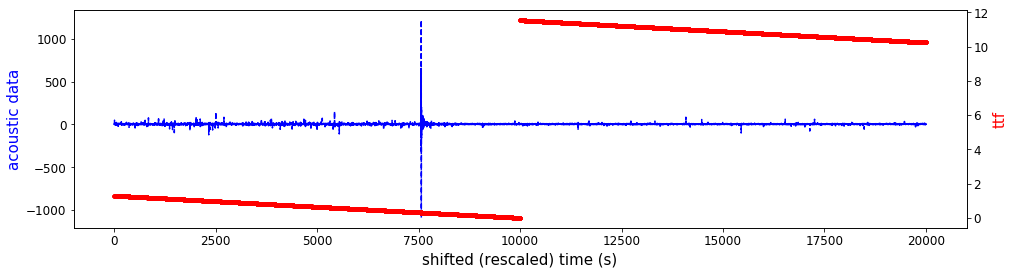

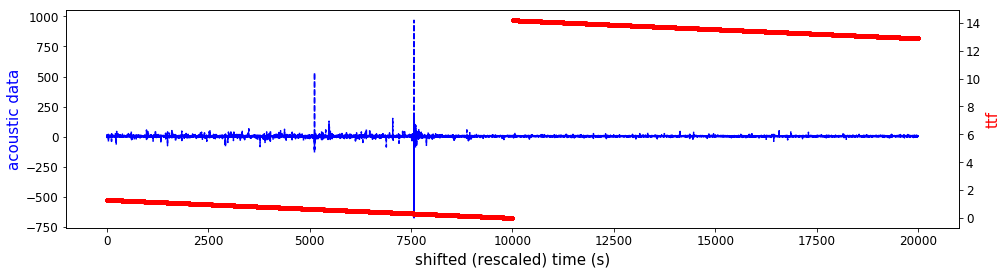

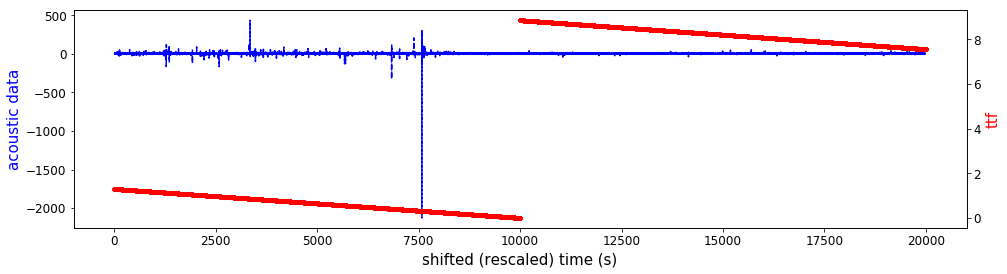

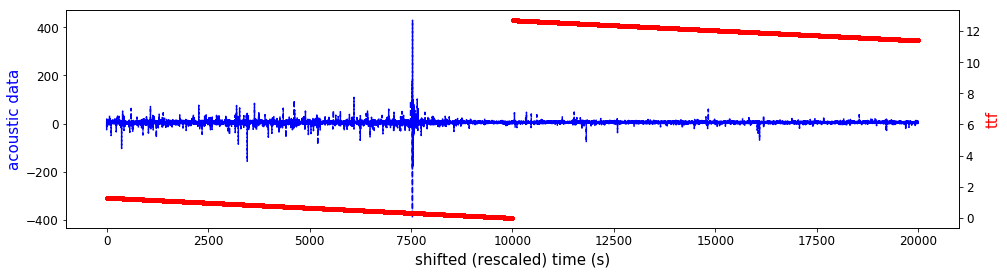

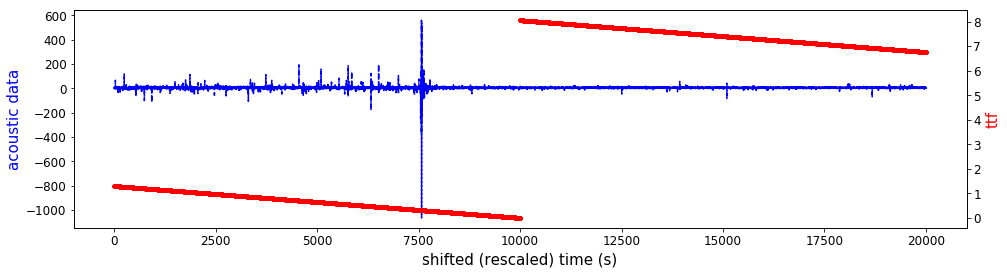

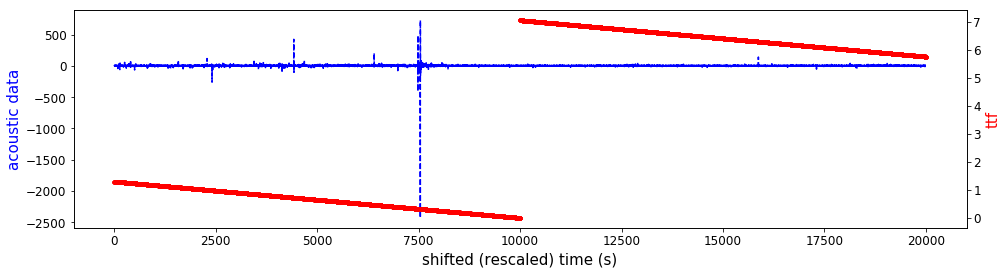

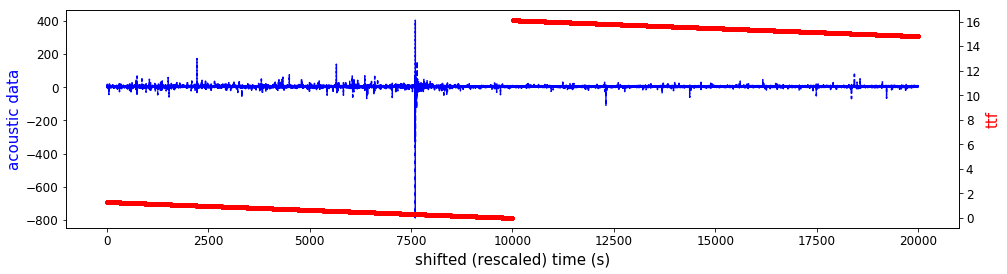

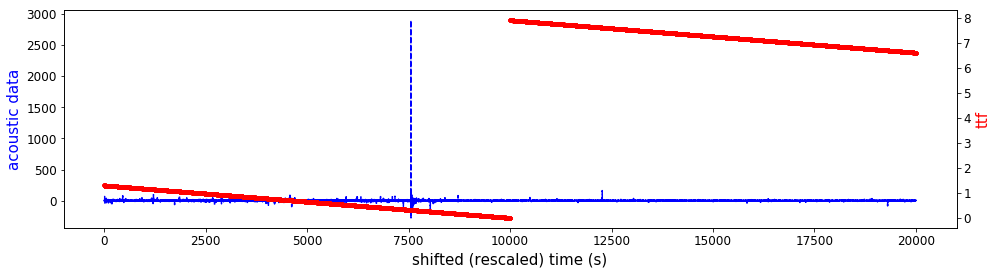

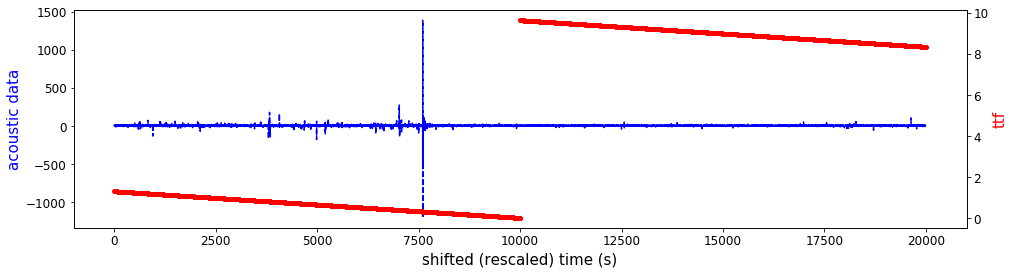

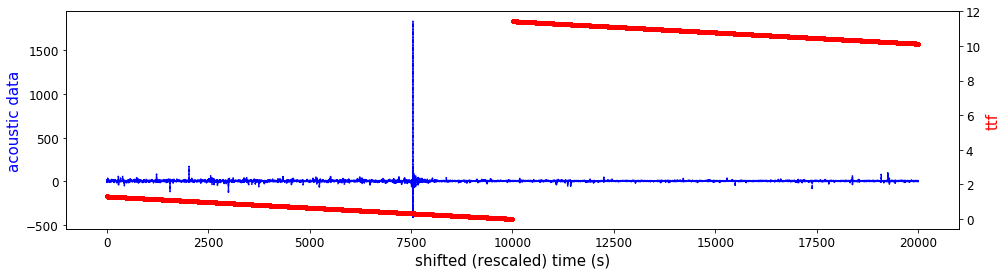

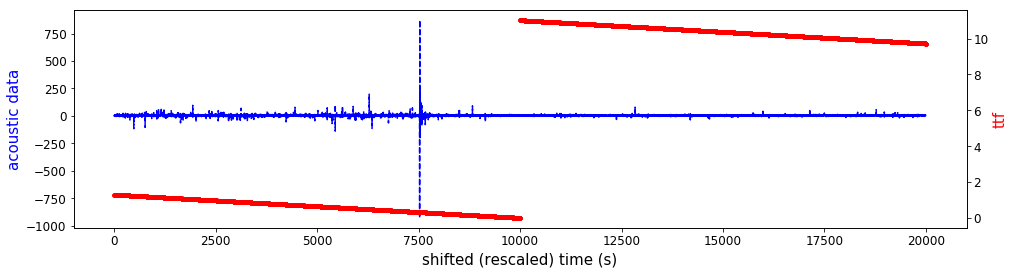

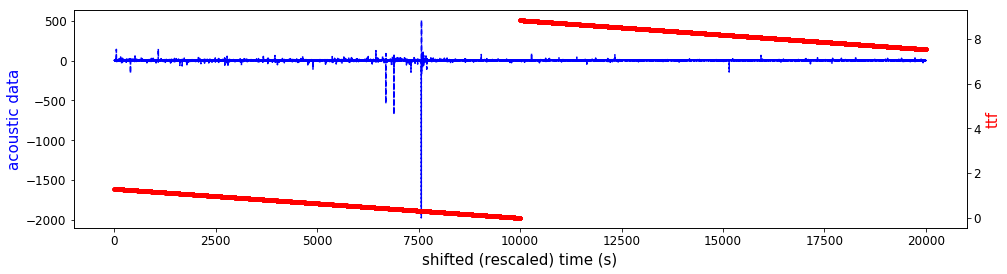

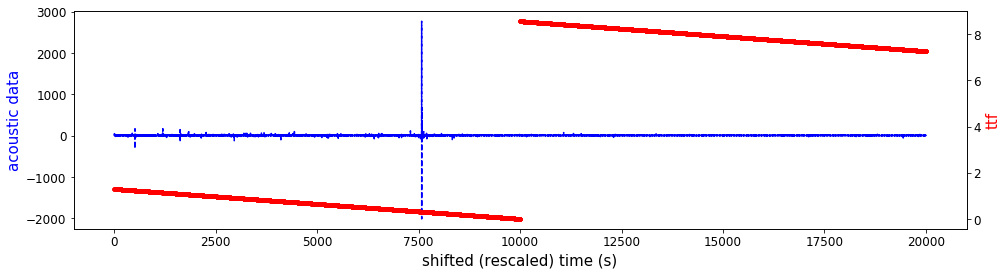

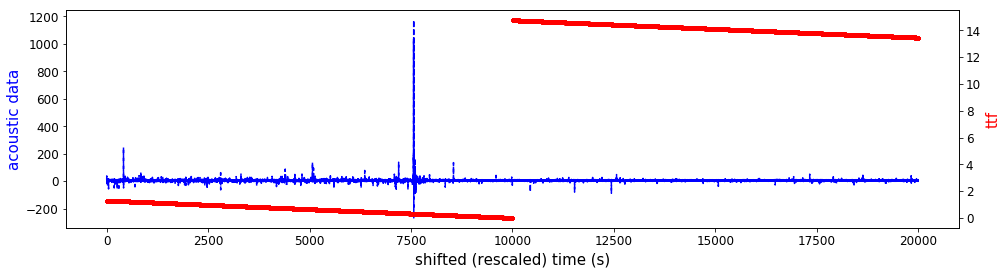

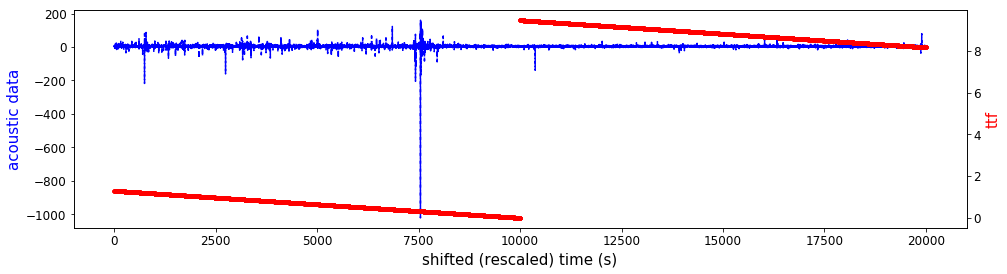

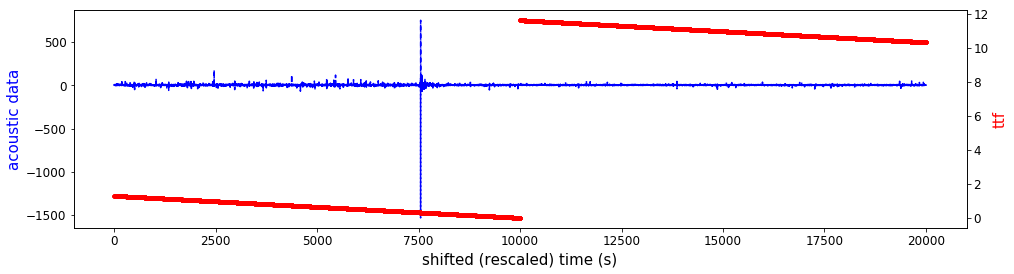

In [256]:
span = int(5*1e6)
step = int(span/10000)
m= len(train_ad)

for i in range(n_jumps):
    t0 = jumps[i]-span
    t1 = jumps[i]+span
    if t0 < 0:
        t0=0
    if t1 > m:
        t1 = m
    ad_jump = train_ad[t0:t1:step] 
    ttf_jump = train_ttf[t0:t1:step] 
    plot_activity(0, 2*int(span/200), x_scale = 2, ad_data = ad_jump, ttf_data = ttf_jump)

Some more inspection of the data

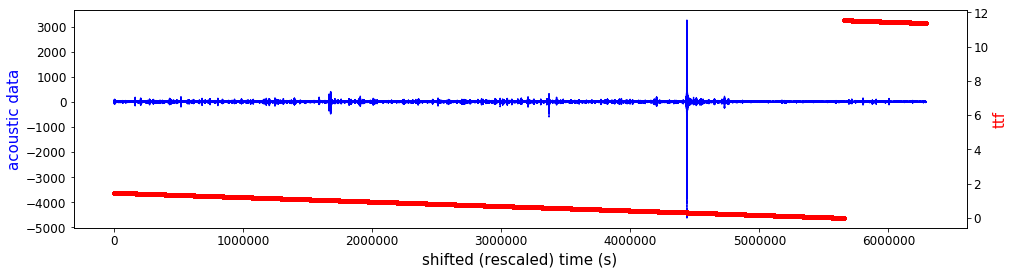

In [250]:
plot_activity(0,int(m/100), x_scale=2)

There is a time lapse of about 500x2500s (=1.25e6 s) between the ad peak and the ttf jump.

Look at the data away from the peaks

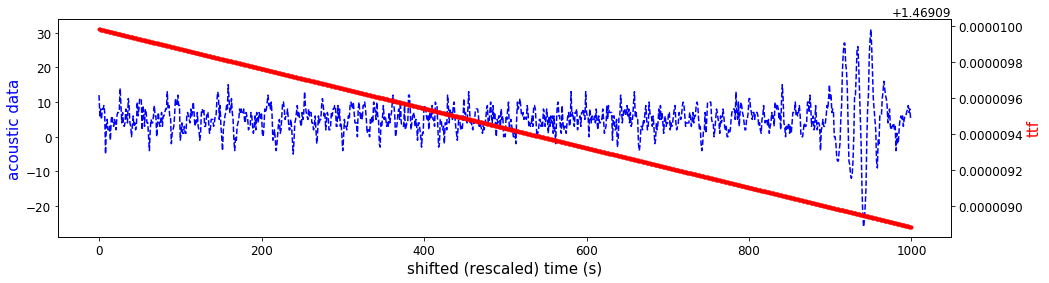

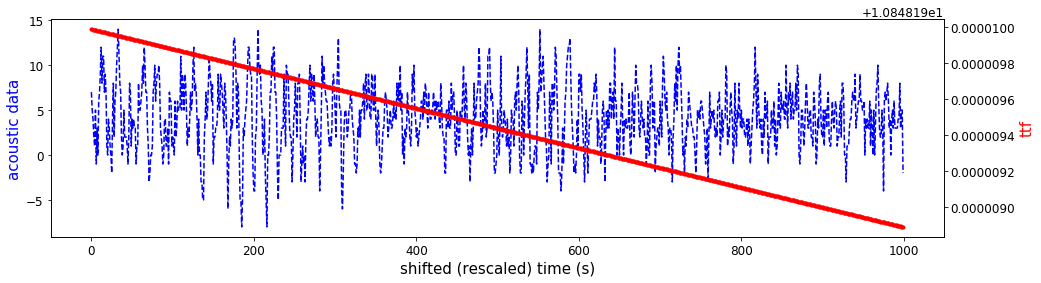

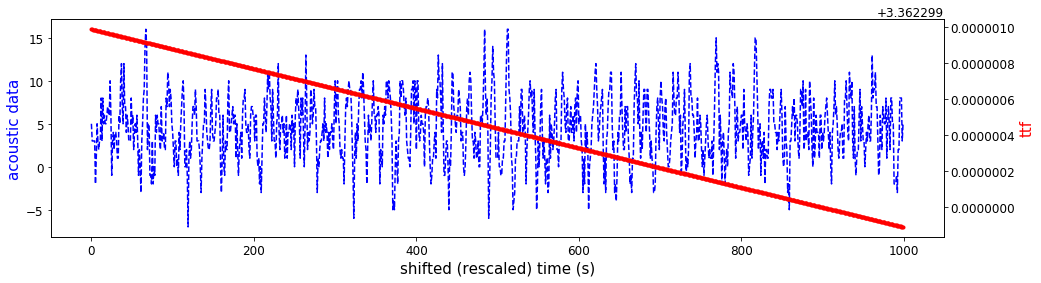

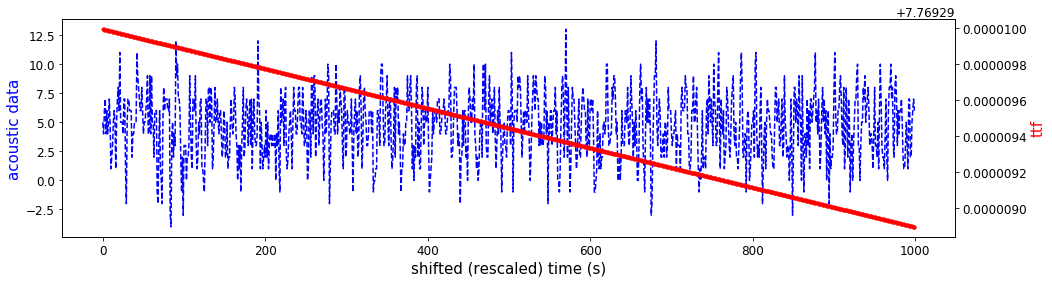

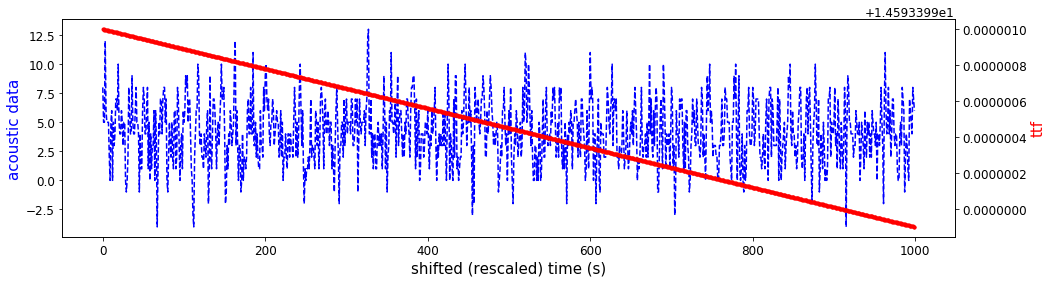

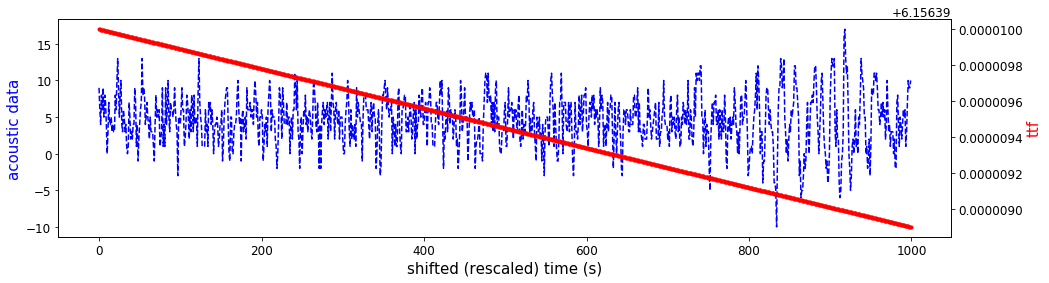

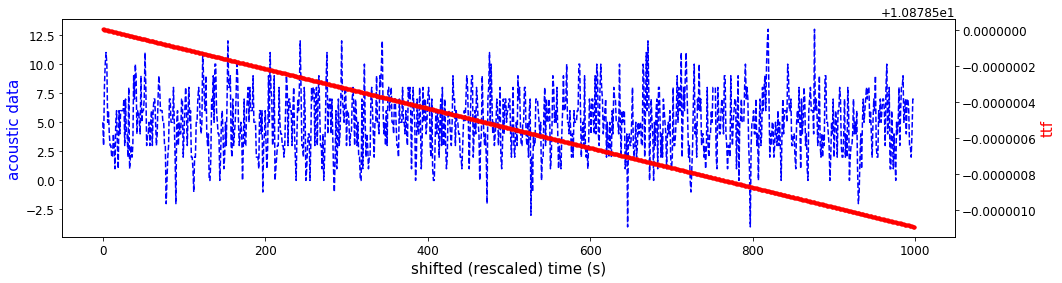

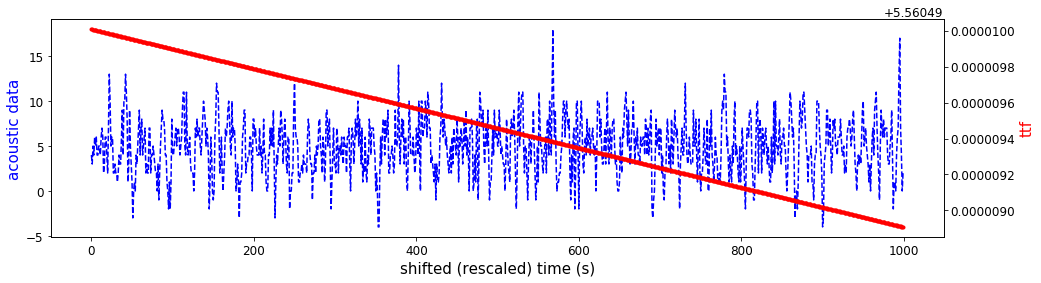

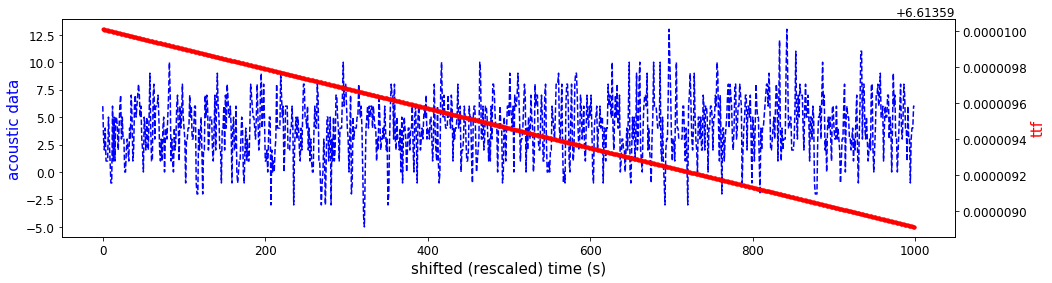

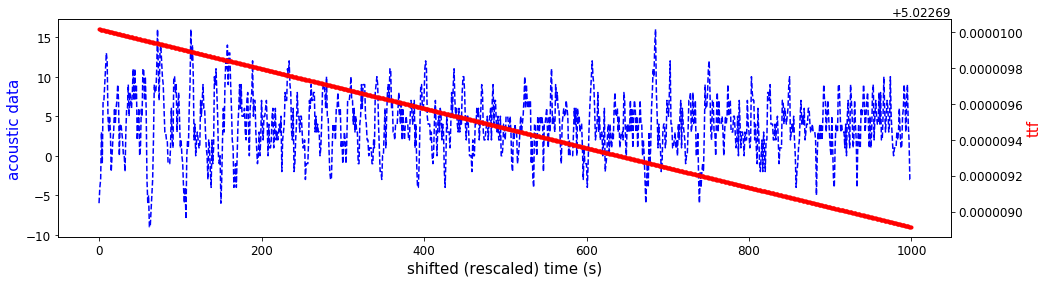

In [308]:
for i in range(10):
    plot_activity(int(i*(m/10)), 1000, x_scale=2)

## Preparing the data

We will split the training set into segments of 150000 instances, as in the test set. Each segment will be one training data and the last ttf value of the segment will be the target data. Then we will create the features that we associate to these training data.

In [9]:
m = len(train)
n_seg_init = int(m/150000)
k=1
n_seg = k*n_seg_init
print(n_seg_init, "\nk =", k)

4194 
k = 1


In [10]:
train_X = pd.DataFrame(index=range(n_seg), dtype=np.float64)
train_y = pd.DataFrame(index=range(n_seg), dtype=np.float64, columns=['time_to_failure'])

### New features

In [18]:
# Auxiliary functions: 

#moving average
def moving_average(a, n) :  # a: 1d array; n: window_size.
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# rolling windows
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

#sta/lta ratio

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [87]:
def create_features(seg_id, seg, X):
    
    ad = seg["acoustic_data"].values.ravel()
    
    # Basic features
    X.loc[seg_id, 'mean'] = ad.mean()
    X.loc[seg_id, 'std'] = ad.std()
    X.loc[seg_id, 'max'] = ad.max()
    X.loc[seg_id, 'min'] = ad.min()
    
    X.loc[seg_id, 'q95'] = np.quantile(ad, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(ad, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(ad, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(ad, 0.01)
    
    # Discrete Fourier Transform
    ad_FT = np.fft.rfft(ad)
    ad_FT_r = np.real(ad_FT)
    ad_FT_i = np.imag(ad_FT)
    
    X.loc[seg_id, 'Rmean'] = ad_FT_r.mean()
    X.loc[seg_id, 'Rstd'] = ad_FT_r.std()
    X.loc[seg_id, 'Rmax'] = ad_FT_r.max()
    X.loc[seg_id, 'Rmin'] = ad_FT_r.min()
    X.loc[seg_id, 'Imean'] = ad_FT_i.mean()
    X.loc[seg_id, 'Istd'] = ad_FT_i.std()
    X.loc[seg_id, 'Imax'] = ad_FT_i.max()
    X.loc[seg_id, 'Imin'] = ad_FT_i.min()
    
    X.loc[seg_id, 'Rmean_last_5000'] = ad_FT_r[-5000:].mean() # Large frequencies features
    X.loc[seg_id, 'Rstd__last_5000'] = ad_FT_r[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = ad_FT_r[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = ad_FT_r[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = ad_FT_r[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = ad_FT_r[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = ad_FT_r[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = ad_FT_r[-15000:].min()
    X.loc[seg_id, 'Imean_last_5000'] = ad_FT_i[-5000:].mean() 
    X.loc[seg_id, 'Istd__last_5000'] = ad_FT_i[-5000:].std()
    X.loc[seg_id, 'Imax_last_5000'] = ad_FT_i[-5000:].max()
    X.loc[seg_id, 'Imin_last_5000'] = ad_FT_i[-5000:].min()
    X.loc[seg_id, 'Imean_last_15000'] = ad_FT_i[-15000:].mean()
    X.loc[seg_id, 'Istd_last_15000'] = ad_FT_i[-15000:].std()
    X.loc[seg_id, 'Imax_last_15000'] = ad_FT_i[-15000:].max()
    X.loc[seg_id, 'Imin_last_15000'] = ad_FT_i[-15000:].min()
    
    # features with abs(ad)
    ad_abs = np.abs(ad)
    
    X.loc[seg_id, 'abs_mean'] = ad_abs.mean()  
    X.loc[seg_id, 'abs_q95'] = np.quantile(ad_abs, 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(ad_abs, 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(ad_abs, 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(ad_abs, 0.01)
    
    X.loc[seg_id, 'count_big'] = len(ad[ad_abs > 500])
    
    # mean change rate
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.divide(np.diff(ad[:50000]), ad[:50000][:-1], out=np.zeros(50000-1), where= ad[:50000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.divide(np.diff(ad[-50000:]), ad[-50000:][:-1], out=np.zeros(50000-1), where= ad[-50000:][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.divide(np.diff(ad[:10000]), ad[:10000][:-1], out=np.zeros(10000-1), where= ad[:10000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.divide(np.diff(ad[-10000:]), ad[-10000:][:-1], out=np.zeros(10000-1), where= ad[-10000:][:-1] != 0))
    
    # moving square averages
    ad_sq = ad**2
    ma700 = moving_average(ad_sq, n=700)
    ma1500 = moving_average(ad_sq, n=1500)
    ma3000 = moving_average(ad_sq, n=3000)
    ma6000 = moving_average(ad_sq, n=6000)
    
    X.loc[seg_id, 'Moving_average_700_mean'] = ma700.mean()
    X.loc[seg_id, 'Moving_average_1500_mean'] = ma1500.mean()
    X.loc[seg_id, 'Moving_average_3000_mean'] = ma3000.mean()
    X.loc[seg_id, 'Moving_average_6000_mean'] = ma6000.mean()
    
    X.loc[seg_id, 'Moving_average_700_std'] = ma700.std()
    X.loc[seg_id, 'Moving_average_1500_std'] = ma1500.std()
    X.loc[seg_id, 'Moving_average_3000_std'] = ma3000.std()
    X.loc[seg_id, 'Moving_average_6000_std'] = ma6000.std()
    
    X.loc[seg_id, 'Moving_average_700_q99'] = np.quantile(ma700, 0.99)
    X.loc[seg_id, 'Moving_average_1500_q99'] = np.quantile(ma1500, 0.99)
    X.loc[seg_id, 'Moving_average_3000_q99'] = np.quantile(ma3000, 0.99)
    X.loc[seg_id, 'Moving_average_6000_q99'] = np.quantile(ma6000, 0.99)
    
    X.loc[seg_id, 'Moving_average_700_q95'] = np.quantile(ma700, 0.95)
    X.loc[seg_id, 'Moving_average_1500_q95'] = np.quantile(ma1500, 0.95)
    X.loc[seg_id, 'Moving_average_3000_q95'] = np.quantile(ma3000, 0.95)
    X.loc[seg_id, 'Moving_average_6000_q95'] = np.quantile(ma6000, 0.95)
    
    # sta/lta ratios
    sta_lta_1 = classic_sta_lta(ad, 500, 10000)
    sta_lta_2 = classic_sta_lta(ad, 5000, 100000)
    sta_lta_3 = classic_sta_lta(ad, 5000, 100000)
    sta_lta_4 = classic_sta_lta(ad, 10000, 25000)
    
    
    X.loc[seg_id, 'classic_sta_lta1_mean'] = sta_lta_1.mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = sta_lta_2.mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = sta_lta_3.mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = sta_lta_4.mean()
    
    X.loc[seg_id, 'classic_sta_lta1_std'] = sta_lta_1.std()
    X.loc[seg_id, 'classic_sta_lta2_std'] = sta_lta_2.std()
    X.loc[seg_id, 'classic_sta_lta3_std'] = sta_lta_3.std()
    X.loc[seg_id, 'classic_sta_lta4_std'] = sta_lta_4.std()
    
    X.loc[seg_id, 'classic_sta_lta1_max'] = sta_lta_1.max()
    X.loc[seg_id, 'classic_sta_lta2_max'] = sta_lta_2.max()
    X.loc[seg_id, 'classic_sta_lta3_max'] = sta_lta_3.max()
    X.loc[seg_id, 'classic_sta_lta4_max'] = sta_lta_4.max()
    
    X.loc[seg_id, 'classic_sta_lta1_q99'] = np.quantile(sta_lta_1, 0.99)
    X.loc[seg_id, 'classic_sta_lta2_q99'] = np.quantile(sta_lta_2, 0.99)
    X.loc[seg_id, 'classic_sta_lta3_q99'] = np.quantile(sta_lta_3, 0.99)
    X.loc[seg_id, 'classic_sta_lta4_q99'] = np.quantile(sta_lta_4, 0.99)
    X.loc[seg_id, 'classic_sta_lta1_q95'] = np.quantile(sta_lta_1, 0.95)
    X.loc[seg_id, 'classic_sta_lta2_q95'] = np.quantile(sta_lta_2, 0.95)
    X.loc[seg_id, 'classic_sta_lta3_q95'] = np.quantile(sta_lta_3, 0.95)
    X.loc[seg_id, 'classic_sta_lta4_q95'] = np.quantile(sta_lta_4, 0.95)
    
    # Rolling window features
    for windows in [10, 100, 1000]:
        x_roll_std = np.std(rolling_window(ad, windows), axis=1)
        x_roll_mean = np.mean(rolling_window(ad, windows), axis=1)
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [15]:
Ben_ad = test[0].values.ravel()
Ben_ad[:10]

array([2, 6, 5, 6, 9, 9, 7, 8, 3, 1])

In [40]:
np.std(rolling_window(Ben_ad, window=10), axis=1)

array([2.69072481, 2.69072481, 2.72763634, ..., 3.12409987, 3.31662479,
       3.63868108])

In [86]:
np.mean(np.divide(np.diff(Ben_ad[:50000]), Ben_ad[:50000][:-1], where= Ben_ad[:50000][:-1] != 0))
np.mean(np.divide(np.diff(Ben_ad[-50000:]), Ben_ad[-50000:][:-1], out = np.zeros(50000-1), where= Ben_ad[-50000:][:-1] != 0))

-0.02701991053314038

### Creating the train data

In [90]:
n_rows = 150000

for seg_id in range(n_seg):
    seg = train[int((seg_id/k)*n_rows):int(((seg_id/k)+1)*n_rows)]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in true_divide
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide


In [91]:
print(train_X.shape, train_y.shape)

(4194, 144) (4194, 1)


In [92]:
train_X.head()

,mean,std,max,min,q95,q99,q05,q01,Rmean,Rstd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113,5.101089,104.0,-98.0,11.0,18.0,-2.0,-8.0,16.883388,3016.543737,...,0.295715,5.629,3.896,4.072,4.379,5.338,5.484,-0.000002,74222.343443,5.629
1,4.725767,6.588802,181.0,-154.0,12.0,21.0,-2.0,-11.0,9.730870,3151.865170,...,0.231587,5.667,3.412,4.233,4.345,5.066,5.223,-0.000002,74364.426478,5.667
2,4.906393,6.967374,140.0,-106.0,13.0,26.0,-3.0,-15.0,9.907775,3288.179260,...,0.267012,5.957,4.055,4.239,4.446,5.344,5.486,0.000001,74594.984584,5.957
3,4.902240,6.922282,197.0,-199.0,12.0,22.0,-2.0,-12.0,9.903708,3289.078383,...,0.266700,5.858,3.722,4.304,4.433,5.317,5.453,-0.000003,74333.143623,5.858
4,4.908720,7.301086,145.0,-126.0,12.0,26.0,-2.0,-15.0,16.909468,3352.776779,...,0.228005,6.078,3.918,4.434,4.543,5.306,5.491,0.000002,74428.435969,6.078


In [93]:
train_y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


In [94]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(train_X)
y_train = train_y.values.ravel()

In [95]:
print(X_train.shape, y_train.shape)

(4194, 144) (4194,)


In [96]:
X_train[:3,:5]

array([[ 1.4241405 , -0.17021358, -0.21819351,  0.19321819, -0.0983931 ],
       [ 0.80571603,  0.00473402,  0.06393601, -0.01803727,  0.32569677],
       [ 1.51115526,  0.0492522 , -0.0862888 ,  0.16303883,  0.74978665]])

In [97]:
y_train[:3]

array([1.43079719, 1.39149889, 1.35319609])

### Preparing the test data

In [98]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [99]:
submission.shape, test_X.shape

((2624, 1), (2624, 144))

In [100]:
for i in range(len(test)):
    seg = test[i]
    seg_id = test_X.index[i]
    create_features(seg_id, seg, test_X)

/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: divide by zero encountered in true_divide
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in true_divide
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: divide by zero encountered in true_divide
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide


In [101]:
test_X.shape

(2624, 144)

In [102]:
X_test = scaler.fit_transform(test_X)

In [103]:
X_test.shape

(2624, 144)

In [104]:
X_test[:3,:5]

array([[ 7.33705337e-01, -6.33812829e-02,  6.98690901e-02,
        -7.51754640e-02,  4.71885606e-04],
       [-1.58009073e+00,  8.25061680e-01,  1.58905243e+00,
        -6.82753752e-01,  8.25957105e-01],
       [-1.64959125e-01, -2.68837289e-01, -4.03971428e-01,
         3.84799059e-01, -4.12270724e-01]])

## Model

In [106]:
from lightgbm import LGBMRegressor

In [107]:
from sklearn.model_selection import KFold

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values

In [108]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [109]:
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train,y_train)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = X_train[trn_idx], X_train[val_idx]
    y_tr, y_val = y_train[trn_idx], y_train[val_idx]

    model = LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(X_test, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95291	valid_1's l1: 2.27134
[2000]	training's l1: 1.556	valid_1's l1: 2.14273
[3000]	training's l1: 1.32049	valid_1's l1: 2.11623
[4000]	training's l1: 1.14017	valid_1's l1: 2.11445
Early stopping, best iteration is:
[3537]	training's l1: 1.21922	valid_1's l1: 2.11293
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.94445	valid_1's l1: 2.26931
[2000]	training's l1: 1.54992	valid_1's l1: 2.1414
[3000]	training's l1: 1.31863	valid_1's l1: 2.12138
[4000]	training's l1: 1.14083	valid_1's l1: 2.11718
[5000]	training's l1: 0.995255	valid_1's l1: 2.11569
[6000]	training's l1: 0.87387	valid_1's l1: 2.11501
[7000]	training's l1: 0.769522	valid_1's l1: 2.11514
Early stopping, best iteration is:
[6777]	training's l1: 0.791449	valid_1's l1: 2.11456
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.95751	valid_1's l1: 

In [110]:
feature_importance_df.head()

,Feature,importance,fold
0,mean,1314,1
1,std,269,1
2,max,1024,1
3,min,611,1
4,q95,271,1


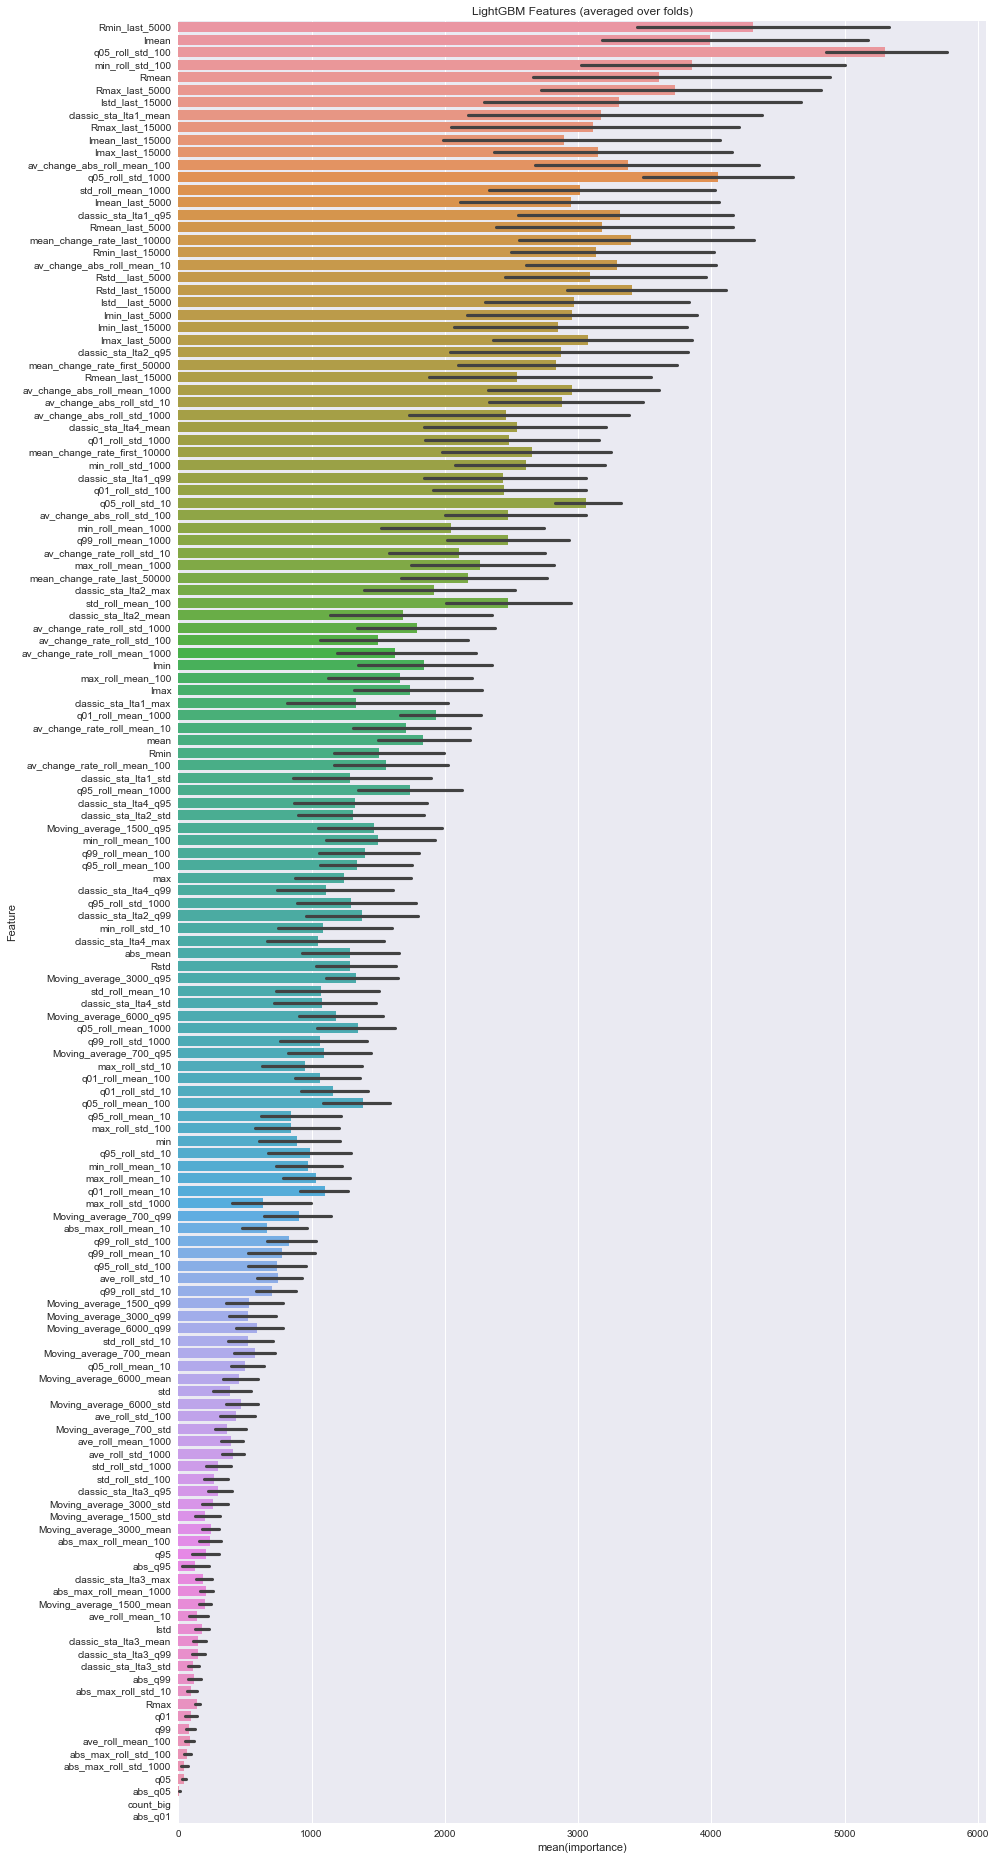

In [111]:
import seaborn as sns

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [113]:
predictions[:10]

array([4.02621038, 4.06716232, 6.07001614, 8.35590293, 4.61715943,
       5.68197272, 9.09735223, 3.00172071, 6.27194159, 7.02358144])

### Submission

In [112]:
submission.time_to_failure = predictions
submission.to_csv('submission_02.csv',index=True)

In [115]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,4.026210
seg_0012b5,4.067162
seg_00184e,6.070016
seg_003339,8.355903
seg_0042cc,4.617159


## Kernel Gab

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold

In [42]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [43]:
def create_features_gab(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [72]:
def create_features_03(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.divide(np.diff(xc), xc[:-1], out=np.zeros(150000-1), where= xc[:-1] != 0))
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    #X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    xc_max = xc.max()
    xc_min = xc.min()
    X.loc[seg_id, 'max_to_min'] = np.divide(xc_max, np.abs(xc_min), out = np.zeros(1), where = xc_min != 0) 
    X.loc[seg_id, 'max_to_min_diff'] = xc_max - np.abs(xc_min)
    #X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    #X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.divide(np.diff(xc[:50000]), xc[:50000][:-1], out=np.zeros(50000-1), where= xc[:50000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.divide(np.diff(xc[-50000:]), xc[-50000:][:-1], out=np.zeros(50000-1), where= xc[-50000:][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.divide(np.diff(xc[:10000]), xc[:10000][:-1], out=np.zeros(10000-1), where= xc[:10000][:-1] != 0))
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.divide(np.diff(xc[-10000:]), xc[-10000:][:-1], out=np.zeros(10000-1), where= xc[-10000:][:-1] != 0))
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    #X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    #X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    #X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    #X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_std), x_roll_std[:-1], out= np.zeros(len(x_roll_std)-1), where= x_roll_std[:-1] !=0))
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        #X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.divide(np.diff(x_roll_mean), x_roll_mean[:-1], out=np.zeros(len(x_roll_mean)-1), where= x_roll_mean[:-1]!=0))
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [45]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [66]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float32)
train_y = pd.DataFrame(index=range(segments), dtype=np.float32, columns=['time_to_failure'])

In [68]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [70]:
train_y.size

4194

In [69]:
train_y.to_csv('train_y.csv',index=False)

In [73]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features_03(seg_id, seg, train_X)

Widget Javascript not detected.  It may not be installed or enabled properly.


Done with 0 segments
Done with 1000 segments
Done with 2000 segments
Done with 3000 segments
Done with 4000 segments



In [74]:
train_X.shape

(4194, 144)

In [75]:
train_X.to_csv('train_X_03.csv',index=False)

### Creating more segments

In [92]:
segments

4194

In [93]:
train_X_bis = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [94]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.5)*rows):int((seg_id + 1.5)*rows)]
    create_features_03(seg_id, seg, train_X_bis)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [129]:
train_X_1q = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_3q = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [130]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.25)*rows):int((seg_id + 1.25)*rows)]
    create_features_03(seg_id, seg, train_X_1q)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [131]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.75)*rows):int((seg_id + 1.75)*rows)]
    create_features_03(seg_id, seg, train_X_3q)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [106]:
train_y_bis = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [107]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.5)*rows):int((seg_id + 1.5)*rows)]
    train_y_bis.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [99]:
train_X = pd.concat([train_X, train_X_bis], ignore_index=True)

In [114]:
train_y = pd.concat([train_y, train_y_bis], ignore_index=True)

In [132]:
train_y_1q = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_3q = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [133]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.25)*rows):int((seg_id + 1.25)*rows)]
    train_y_1q.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 0.75)*rows):int((seg_id + 1.75)*rows)]
    train_y_3q.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [134]:
train_X = pd.concat([train_X, train_X_1q, train_X_3q], ignore_index=True)
train_y = pd.concat([train_y, train_y_1q, train_y_3q], ignore_index=True)

Even more training data

In [146]:
train_X_18th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_38th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_58th = pd.DataFrame(index=range(segments-1), dtype=np.float32)
train_X_78th = pd.DataFrame(index=range(segments-1), dtype=np.float32)

In [147]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 1/8)*rows):int((seg_id + 1/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_18th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 3/8)*rows):int((seg_id + 3/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_38th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 5/8)*rows):int((seg_id + 5/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_58th)
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 7/8)*rows):int((seg_id + 7/8 +1)*rows)]
    create_features_03(seg_id, seg, train_X_78th)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [144]:
train_y_18th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_38th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_58th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])
train_y_78th = pd.DataFrame(index=range(segments-1), dtype=np.float32, columns=['time_to_failure'])

In [145]:
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 1/8)*rows):int((seg_id + 1/8 + 1)*rows)]
    train_y_18th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 3/8)*rows):int((seg_id + 3/8 +1)*rows)]
    train_y_38th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 5/8)*rows):int((seg_id + 5/8 + 1)*rows)]
    train_y_58th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
for seg_id in tqdm_notebook(range(segments-1)):
    seg = train.iloc[int((seg_id + 7/8)*rows):int((seg_id + 7/8 +1)*rows)]
    train_y_78th.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [148]:
train_X = pd.concat([train_X, train_X_18th, train_X_38th, train_X_58th, train_X_78th], ignore_index=True)
train_y = pd.concat([train_y, train_y_18th, train_y_38th, train_y_58th, train_y_78th], ignore_index=True)

In [149]:
print(train_X.shape, train_y.shape)

(33545, 144) (33545, 1)


In [150]:
train_X.to_csv('train_X_03_x8.csv',index=False)

In [151]:
train_y.to_csv('train_y_x8.csv',index=False)

### Getting back train_X and train_y (if program crashed)

In [166]:
train_X = pd.read_csv("train_X_03_more.csv")
train_y = pd.read_csv("train_y_more.csv")

In [167]:
train_X.shape

(8387, 144)

In [168]:
train_y.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274399


### Scaling

In [169]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [171]:
scaled_train_X.head(3)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.423784,-0.169758,-0.217548,0.192852,1.120636,-0.104643,1.423784,0.153900,-0.234100,-0.168587,...,0.269547,-0.004781,0.177824,0.286354,0.962953,1.505666,0.889626,-0.637375,-0.003286,-0.004781
1,0.805551,0.005124,0.064694,-0.018570,0.071298,-0.008278,0.805551,-0.223084,-0.452315,0.007610,...,-0.139981,0.007304,-0.025857,0.623026,0.840476,0.521874,0.296736,-0.918385,-0.001124,0.007304
2,1.510772,0.049626,-0.085591,0.162649,0.071298,0.044096,1.510772,-0.105802,0.791509,0.055220,...,0.086247,0.099534,0.244736,0.635572,1.204305,1.527368,0.894169,0.436032,0.001407,0.099534


### Preparing Test set

In [79]:
submission = pd.read_csv('datasets/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float32, index=submission.index)

In [123]:
submission.shape, test_X.shape

((2624, 1), (2624, 144))

In [81]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('datasets/test/' + seg_id + '.csv')
    create_features_03(seg_id, seg, test_X)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [82]:
test_X.to_csv('test_X_03.csv',index=False)

Getting back test_X if program crashed

In [20]:
test_X = pd.read_csv("test_X_03.csv")

In [124]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [172]:
scaled_test_X.tail(3)

,mean,std,max,min,Rmean,Rstd,Rmax,Rmin,Imean,Istd,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
2621,-3.009655,0.343517,0.537541,-0.581106,-0.228513,0.174496,-3.009655,-0.487273,-0.081350,0.341256,...,-0.165019,-0.130403,-0.336428,-1.574749,-2.621306,-2.946719,-1.940798,1.600577,0.016816,-0.130403
2622,-0.694013,0.782194,0.728146,-0.641513,-0.228513,0.628416,-0.694013,-1.110252,-1.783425,0.778474,...,-0.043986,0.055327,-0.179459,-0.307526,-0.679682,-0.758504,0.008242,0.911976,0.025259,0.055327
2623,-1.248295,-0.349365,-0.331178,0.347644,0.221203,-0.305685,-1.248294,0.384201,-0.790548,-0.349867,...,-0.254687,-0.248075,0.047367,-0.502001,-0.971466,-1.268484,-0.816353,-0.563958,-0.004362,-0.248075


### Training

In [173]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

params = {'num_leaves': 50,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [174]:
from lightgbm import LGBMRegressor

In [175]:
oof = np.zeros(len(scaled_train_X))
predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = LGBMRegressor(**params, n_estimators = 40000, n_jobs = -1)
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_tr, y_tr), (X_val, y_val)], 
              eval_metric='mae',
              verbose=1000, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.06131	valid_1's l1: 2.2051
[2000]	training's l1: 1.75825	valid_1's l1: 2.06714
[3000]	training's l1: 1.59452	valid_1's l1: 2.03806
[4000]	training's l1: 1.46771	valid_1's l1: 2.0283
[5000]	training's l1: 1.36166	valid_1's l1: 2.022
[6000]	training's l1: 1.26875	valid_1's l1: 2.01828
[7000]	training's l1: 1.18448	valid_1's l1: 2.01551
[8000]	training's l1: 1.10756	valid_1's l1: 2.01316
[9000]	training's l1: 1.03639	valid_1's l1: 2.01023
[10000]	training's l1: 0.970612	valid_1's l1: 2.00828
[11000]	training's l1: 0.909724	valid_1's l1: 2.0068
[12000]	training's l1: 0.853341	valid_1's l1: 2.00588
[13000]	training's l1: 0.800873	valid_1's l1: 2.00462
[14000]	training's l1: 0.752015	valid_1's l1: 2.00356
[15000]	training's l1: 0.706249	valid_1's l1: 2.00289
[16000]	training's l1: 0.663604	valid_1's l1: 2.00235
[17000]	training's l1: 0.623749	valid_1's l1: 2.00154
[18000]	training's l1: 0.586491	val

[31000]	training's l1: 0.271621	valid_1's l1: 1.99995
[32000]	training's l1: 0.256339	valid_1's l1: 1.9997
[33000]	training's l1: 0.242007	valid_1's l1: 1.99946
[34000]	training's l1: 0.228444	valid_1's l1: 1.99928
[35000]	training's l1: 0.215632	valid_1's l1: 1.99905
[36000]	training's l1: 0.203691	valid_1's l1: 1.99887
[37000]	training's l1: 0.192362	valid_1's l1: 1.99868
[38000]	training's l1: 0.181719	valid_1's l1: 1.99857
[39000]	training's l1: 0.171708	valid_1's l1: 1.99845
[40000]	training's l1: 0.162291	valid_1's l1: 1.99828
Did not meet early stopping. Best iteration is:
[40000]	training's l1: 0.162291	valid_1's l1: 1.99828
fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.05412	valid_1's l1: 2.26103
[2000]	training's l1: 1.75261	valid_1's l1: 2.10911
[3000]	training's l1: 1.59059	valid_1's l1: 2.0729
[4000]	training's l1: 1.46663	valid_1's l1: 2.06009
[5000]	training's l1: 1.36062	valid_1's l1: 2.05311
[6000]	training's l1: 1.26737	

### Feature importances

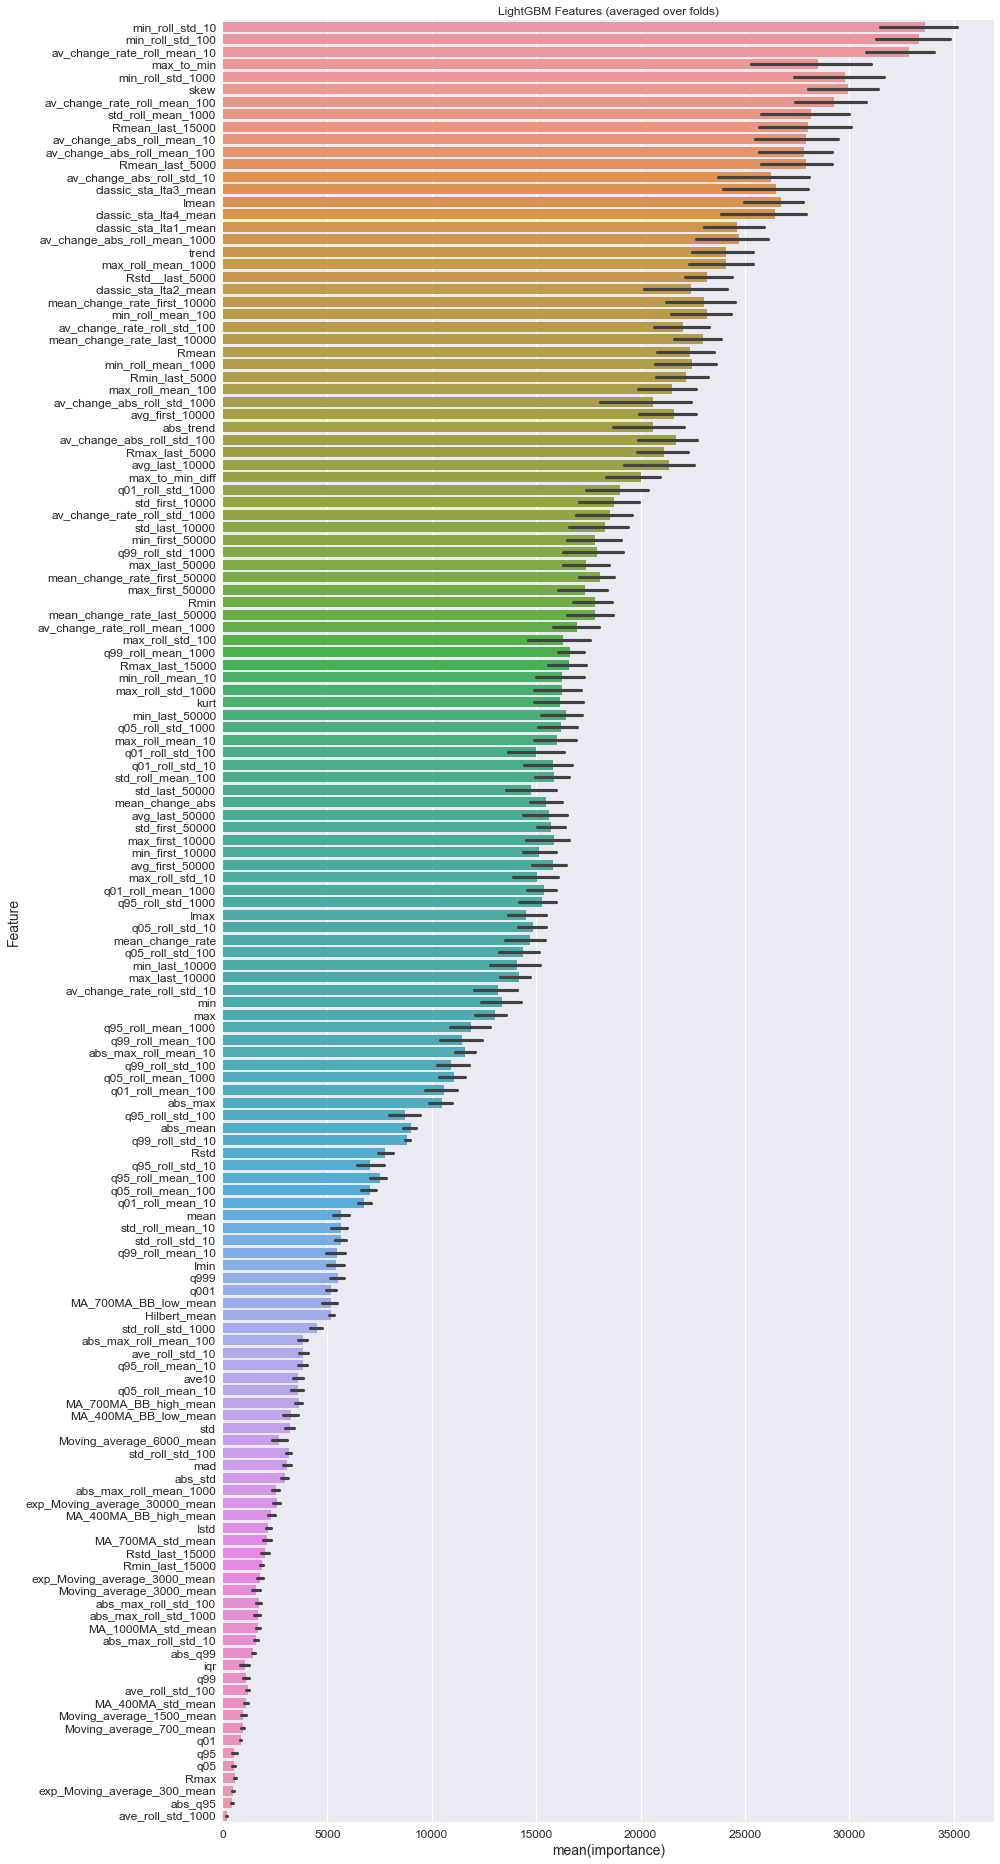

In [176]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances_03_x2.png')

### Submission

In [177]:
submission.time_to_failure = predictions
submission.to_csv('submission_03_x2.csv',index=True)